## Author: Robert Ferdinand
## Title: Data Science Assessment for Legacy.com
## Date: April 11, 2022

In [76]:
# Start with importing the necessary python packages we will need for Data Visualization and Time Series Modeling

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import rcParams

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error as MSE

from itertools import product

In [77]:
# Read in the data as a pandas dataframe. Here the CSV file is renamed as "LegacyData.csv" for convenience

data = pd.read_csv("LegacyData.csv")

In [78]:
# Make a copy of the data read above which will be used for the visual analyses and modeling

df = data.copy()

In [79]:
# Top 5 Rows of Data 

df.head()

,Date,Device Platform,Billed Impressions,Revenue
0,2018-01-01,Desktop,30462789,19801.19
1,2018-01-01,Mobile,15731390,8262.28
2,2018-01-02,Desktop,45868100,27918.80
3,2018-01-02,Mobile,17195748,8575.64
4,2018-01-03,Desktop,49696657,28896.35


In [80]:
# Shape of Data Set ... Number of Rows and Columns

df.shape

(2192, 4)

In [81]:
# Checking for any null values ... 

df.isnull().sum()

Date                  0
Device Platform       0
Billed Impressions    0
Revenue               0
dtype: int64

In [82]:
# Bottom 5 Rows of Data Set

df.tail()

,Date,Device Platform,Billed Impressions,Revenue
2187,2020-12-29,Mobile,13012979,14474.56
2188,2020-12-30,Desktop,31684411,34198.18
2189,2020-12-30,Mobile,12585784,12646.91
2190,2020-12-31,Desktop,29404779,27747.48
2191,2020-12-31,Mobile,12067841,10829.37


In [83]:
# Data Types of Columns of Data Set

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2192 non-null   object 
 1   Device Platform     2192 non-null   object 
 2   Billed Impressions  2192 non-null   int64  
 3   Revenue             2192 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 68.6+ KB


In [84]:
df['Device Platform'].value_counts()

Desktop    1096
Mobile     1096
Name: Device Platform, dtype: int64

In [85]:
df["Device Platform"].nunique()

2

In [86]:
df['Device Platform'].unique()

array(['Desktop', 'Mobile'], dtype=object)

**Observations:** This confirms there are only 2 types of Device Platforms, ***Mobile*** and ***Desktop***, each of whose revenues will be forecast separately, for the year 2021.

In [87]:
# Converting Date column to datetime format to facilitate Time Series Modeling

df['Date'] = pd.to_datetime(df['Date'])

In [88]:
# Top 5 Rows of New Data Frame 

df.head()

,Date,Device Platform,Billed Impressions,Revenue
0,2018-01-01,Desktop,30462789,19801.19
1,2018-01-01,Mobile,15731390,8262.28
2,2018-01-02,Desktop,45868100,27918.80
3,2018-01-02,Mobile,17195748,8575.64
4,2018-01-03,Desktop,49696657,28896.35


In [89]:
# Separating the Desktop and Mobile Device Data via Slicing to Model Each Separately

dfMobile = df[df['Device Platform'] == 'Mobile']

dfDesktop = df[df['Device Platform'] == 'Desktop']

# Part (I): Exploratory Analyses and Modeling for Mobile Devices

In [90]:
# Grouping the Mobile Revenue by Monthly Totals to Predict Total Monthly Revenues via Time Series

dfMobileRevenue = dfMobile.groupby(pd.Grouper(key = 'Date', freq = 'M')).agg({'Revenue' : 'sum'})

In [91]:
# The following code is used to set subsequent figure sizes

rcParams['figure.figsize'] = 20,8

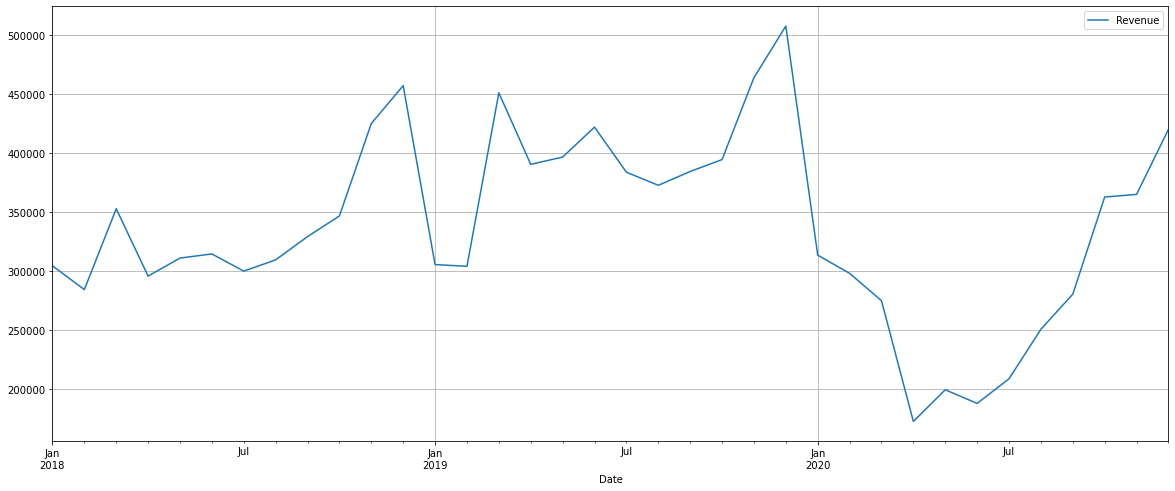

In [92]:
# Time Series Plot of Monthly Mobile Revenue

dfMobileRevenue.plot()
plt.grid();

**Observations:** The Mobile Revenue Data looks pretty seasonal with Revenues peaking towards the end of the year. Also there appears to be an increasing trend through each year. 2020 Revenues seem to be down compared to previous two years.

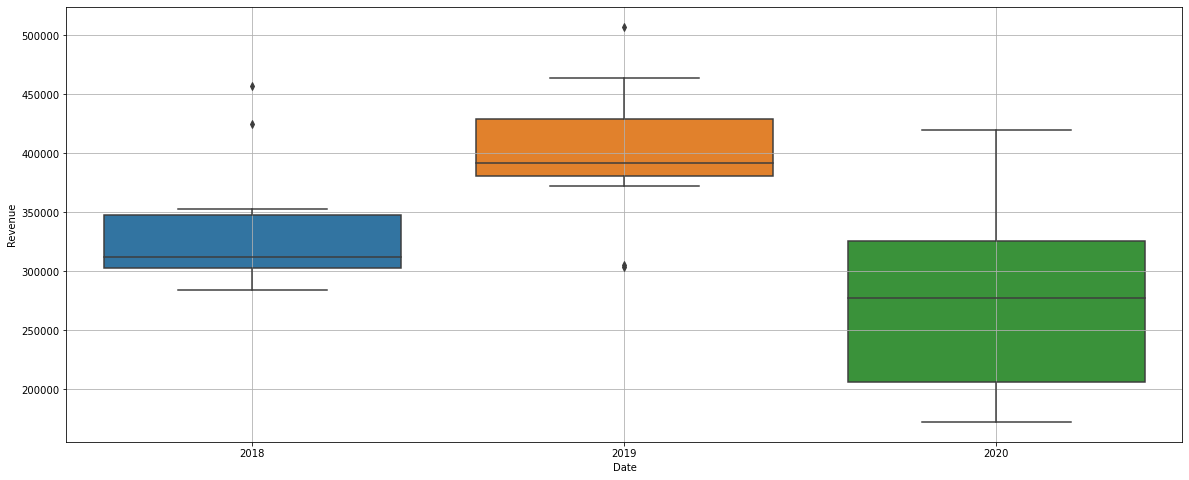

In [93]:
# Box Plots By Year of Mobile Revenue Data

sns.boxplot(x = dfMobileRevenue.index.year, y = dfMobileRevenue['Revenue'])
plt.grid();

**Observations:** 2019 seems to have the highest Mobile Revenue. 2020 has the highest spread of revenue.

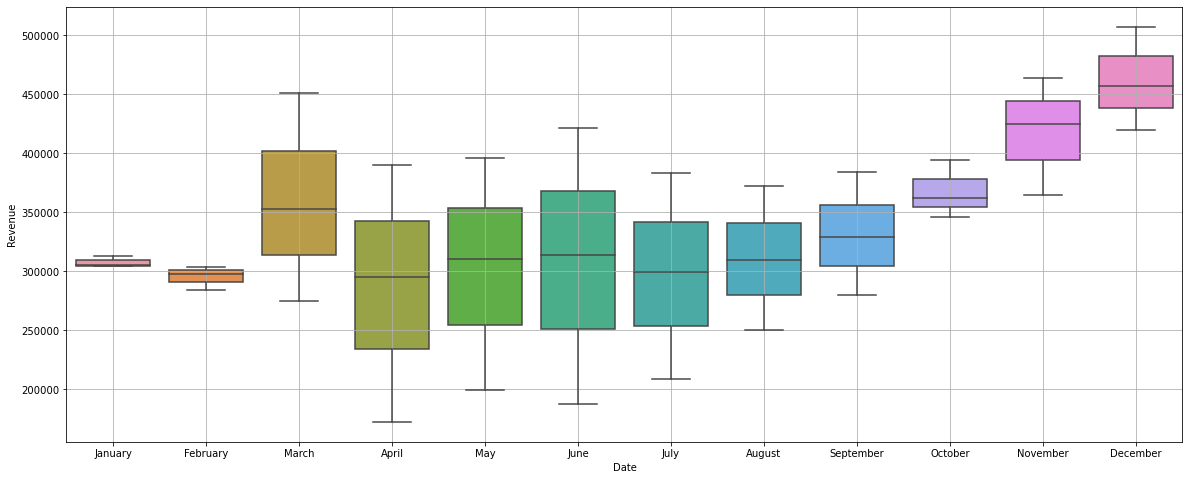

In [94]:
# Box Plots of Mobile Revenue Data by Month

sns.boxplot(x = dfMobileRevenue.index.month_name(), y = dfMobileRevenue['Revenue'])
plt.grid();

**Observations:** Highest Mobile Revenues in November-December with highest spread in the summer months of May-July.

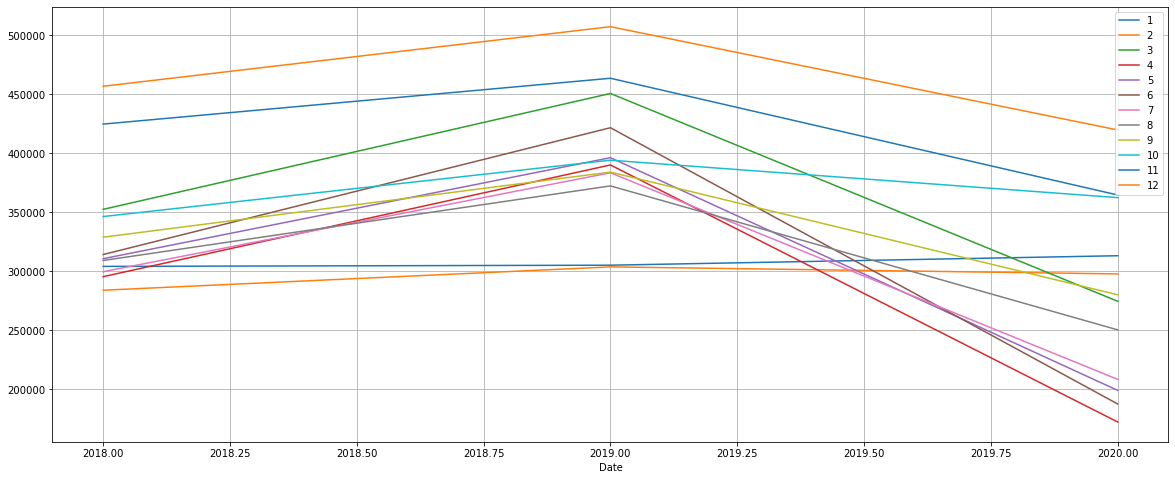

In [95]:
# Creating Pivot Table and Line Plots of Monthly Revenues

annualMonthlySales = pd.pivot_table(dfMobileRevenue, values = 'Revenue', columns = dfMobileRevenue.index.month,\
                                            index = dfMobileRevenue.index.year)

annualMonthlySales.plot()
plt.grid()
plt.legend(loc='best');

**Observations:** Highest Mobile Revenues in November-December.

### Since the data is measuring the same value at successive points in time, where the step-size of the time grid is uniform, we use a Time Series for forecasting revenue values for the not too distance future. Therefore, we proceed as follows:

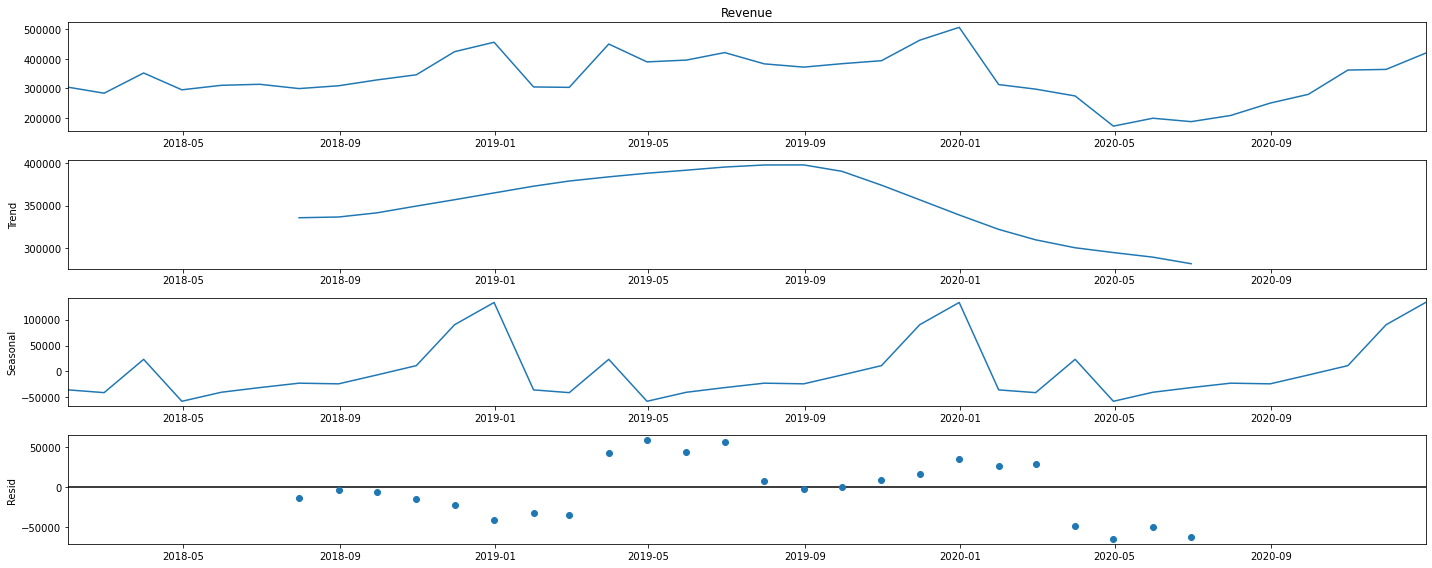

In [96]:
# Decompose data using an Additive model

decomposition = seasonal_decompose(dfMobileRevenue.Revenue, model = 'additive')
decomposition.plot();

**Observations:** Definite seasonality in data. Significant irregular component with high variance centered around 0.

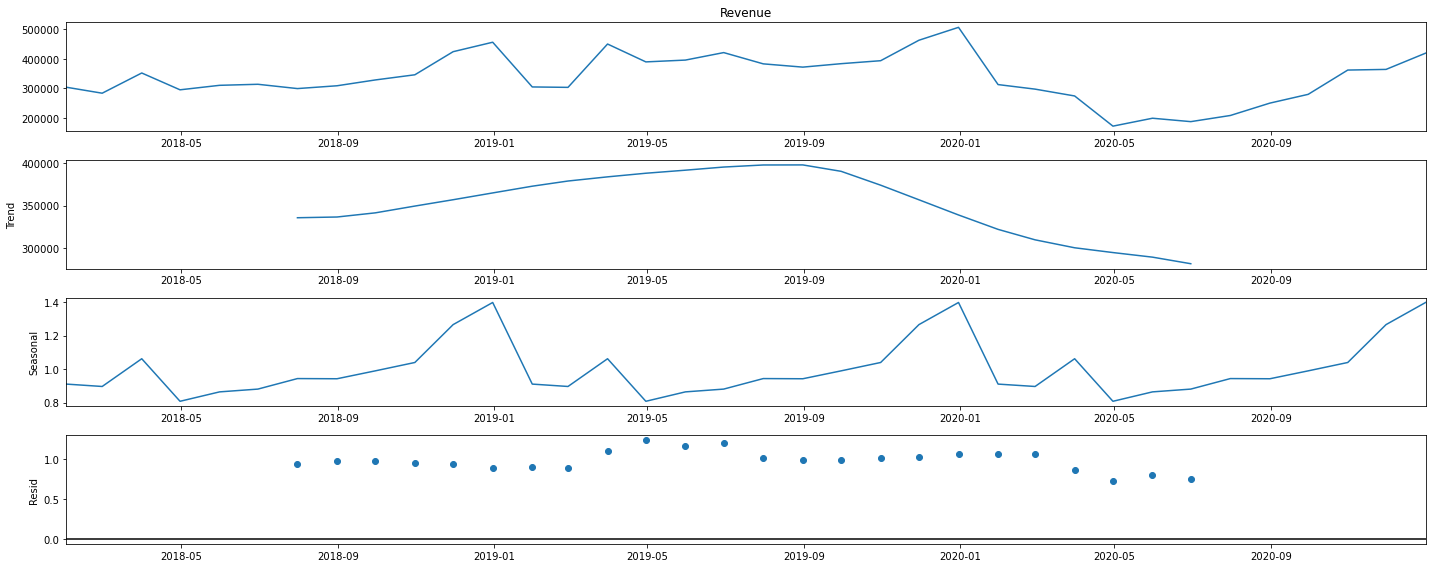

In [97]:
# Decompose data using a Multiplicative model

decomposition = seasonal_decompose(dfMobileRevenue.Revenue, model = 'multiplicative')
decomposition.plot();

**Observations:** Definite seasonality in data. Irregular component, centered at 1, has much smaller variance compared to the additive model.

In [98]:
## Test for stationarity of the Time Series using the Augmented Dicky-Fuller (ADF) Test. Write a function to analyze.

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = 7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window = 7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label ='Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')
    return

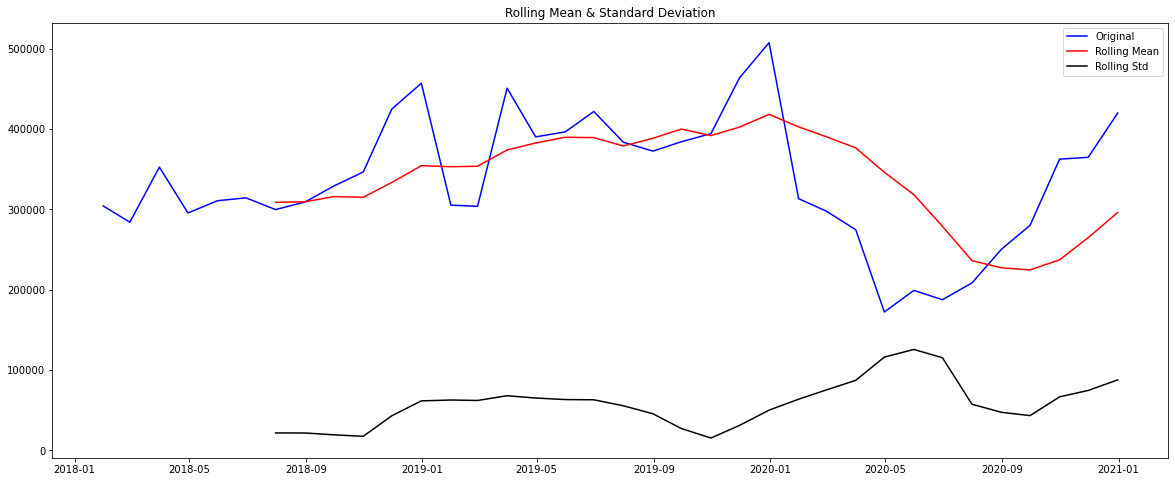

Results of Dickey-Fuller Test:
Test Statistic                 -2.355906
p-value                         0.154570
#Lags Used                      0.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64 



In [99]:
# Call function above on Mobile Revenue data

test_stationarity(dfMobileRevenue.Revenue)

**Observations:** p-value is greater than 0.05 or 5% significance level. Hence we fail to reject the null hypothesis that data has no stationarity.

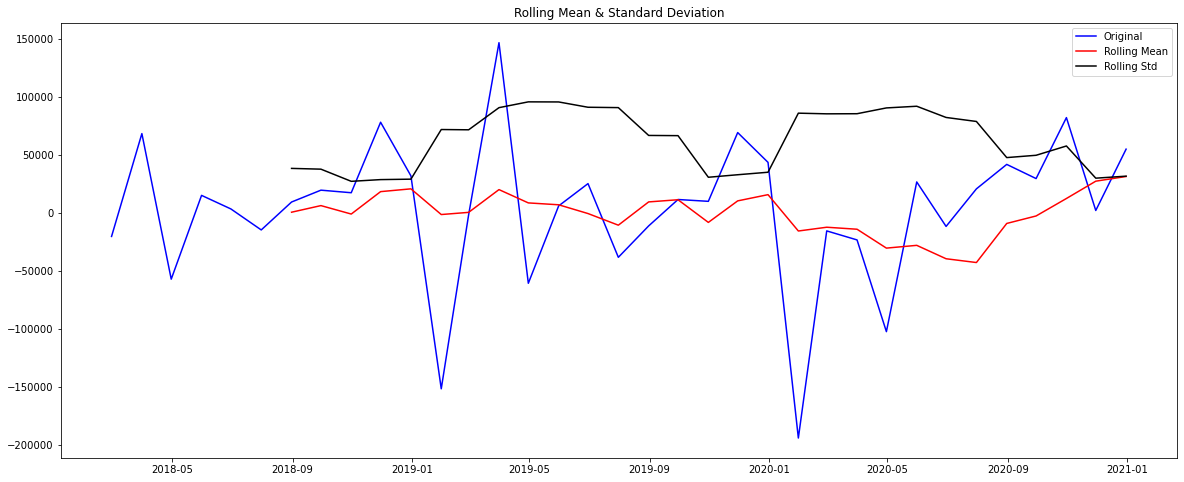

Results of Dickey-Fuller Test:
Test Statistic                 -5.162151
p-value                         0.000010
#Lags Used                      1.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64 



In [100]:
# Try ADF Test on first-level differenced data

test_stationarity(dfMobileRevenue.Revenue.diff().dropna())

**Observations:** p-value is less than 0.05 or 5% significance level. Hence we fail to accept the null hypothesis that data has no stationarity. Data has been stationarized. So we will need a difference value of d = D = 1 to apply a time series model to the data.

In [101]:
# Starting with Time Series Modeling, we split Mobile Revenue Data into Train Set (70%) and Test Set (30%)

dataSize = dfMobileRevenue.shape[0]

TrainRatio = 0.7

TrainSize = int(np.ceil(dataSize * TrainRatio))

dfMobileRevenueTrain = dfMobileRevenue[:][0:TrainSize]
dfMobileRevenueTest = dfMobileRevenue[:][TrainSize:dataSize]

### Since there is definite Seasonality in the Data, we will use a SARIMA model which stands for Seasonality (S) Auto (A) Regressive (R) Integrated (I) Moving Averages (MA).

In [102]:
# Start with all possible combinations of parameters p (order of the time series), q (order of error terms), 
# d (differences applied to time series to remove stationarity)

# For the present seasonal component, consider all possible combinations of P (order of the time series),  
# Q (order of error terms), D (level of difference applied to time series to remove stationarity) and
# F (frequency of seasonality observations). One may note that F = 12 since the seasonality repeats in
# annual or 12 monthly periods.

# Here we use the product() function from the PYTHON itertools package

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)

pdq = list(product(p, d, q))

P = range(0, 3)
D = range(1, 2)
Q = range(0, 3)
F = range(12, 13)

model_pdq = list(product(P, D, Q, F))

In [103]:
# Run the SARIMA model using SARIMAX() python function for all possible combinations of (p, d, q) and (P, D, Q, F)

SARIMA_AIC = []

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(dfMobileRevenueTrain["Revenue"].values,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
        results_SARIMA = SARIMA_model.fit(maxiter = 1000)
        SARIMA_AIC.append([param, param_seasonal, results_SARIMA.aic])

C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

In [104]:
# Create Data Frame of Akaike Information Criteria (AIC) scores for the models above

SARIMA_AIC = pd.DataFrame(SARIMA_AIC)
SARIMA_AIC.columns = ['Param', 'Seasonal Param', 'AIC']
SARIMA_AIC.sort_values(by = ['AIC']).head()

,Param,Seasonal Param,AIC
1,"(0, 1, 0)","(0, 1, 1, 12)",4.0
30,"(1, 1, 0)","(1, 1, 0, 12)",6.0
2,"(0, 1, 0)","(0, 1, 2, 12)",6.0
28,"(1, 1, 0)","(0, 1, 1, 12)",6.0
4,"(0, 1, 0)","(1, 1, 1, 12)",6.0


**Observations:** Lowest AIC score is for parameter values (p, d, q) = (0, 1, 0) and (P, D, Q, F) = (0, 1, 1, 12)

In [105]:
# Build SARIMA model with the above optimal (p, d, q) = (0, 1, 0) and (P, D, Q, F) = (0, 1, 1, 12) values.
# Fit model to training data set.

model_SARIMA = sm.tsa.statespace.SARIMAX(dfMobileRevenueTrain['Revenue'].values,
                                order = (0, 1, 0),
                                seasonal_order = (0, 1, 1, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)
results_model_SARIMA = model_SARIMA.fit(maxiter = 1000)

C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /


In [106]:
# Predict Using Model Above for points in time equal in length to that of Test Data Set 

predicted_model_SARIMA = results_model_SARIMA.get_forecast(steps = dfMobileRevenueTest.shape[0])

In [107]:
# Top 5 Rows of Predicted Data

predicted_model_SARIMA.summary_frame(alpha = 0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,444715.79,27241.081887,391324.250602,498107.329398
1,384130.06,38524.707458,308623.020868,459637.099132
2,390290.04,47182.937881,297813.181069,482766.898931
3,415677.04,54482.163773,308893.961204,522460.118796
4,377490.96,60912.910879,258103.848483,496878.071517


In [108]:
# Calculate Root Mean Square Error between predicted data and test data

rmse = MSE(dfMobileRevenueTest['Revenue'],\
                          predicted_model_SARIMA.predicted_mean, squared = False)
print('Root Mean Square Error (RMSE) = %.2f' % rmse)

Root Mean Square Error (RMSE) = 151685.47


In [109]:
# Build Time Series SARIMAX Model on Whole Data Set (Test + Train Data Sets)

full_data_model = sm.tsa.statespace.SARIMAX(dfMobileRevenue['Revenue'],
                                order = (0, 1, 0),
                                seasonal_order = (1, 1, 1, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)
results_full_data_model = full_data_model.fit(maxiter = 1000)
print(results_full_data_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              Revenue   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -120.191
Date:                              Sun, 10 Apr 2022   AIC                            246.382
Time:                                      22:39:28   BIC                            247.290
Sample:                                  01-31-2018   HQIC                           245.386
                                       - 12-31-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.8705      2.488     -0.752      0.452      -6.747       3.006
ma.S.L12      -0.08

C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [110]:
# RMSE of Full Data Model

rmse = MSE(dfMobileRevenue['Revenue'], results_full_data_model.fittedvalues, squared = False)
print('RMSE of the Full Data Model = %.2f' % rmse)
averageMeanColumn = dfMobileRevenue['Revenue'].mean()
print('Average of Mean Column = %.2f' % averageMeanColumn)

RMSE of the Full Data Model = 145319.06
Average of Mean Column = 336906.05


In [111]:
# Predict for the future 12 months of the year 2021

predicted_SARIMA_full_data = results_full_data_model.get_forecast(steps = 12)

In [112]:
# Top 5 Rows of Predicted 2021 Total Monthly Revenue Data for Mobile

predicted_SARIMA_full_data.summary_frame(alpha = 0.05).head()

Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-31,368820.256725,49593.319985,271619.135680,466021.377770
2021-02-28,377847.269514,70135.414942,240384.382186,515310.156841
2021-03-31,673331.998776,85897.936361,504975.137162,841688.860391
2021-04-30,654266.734120,99186.362536,459865.035793,848668.432448
2021-05-31,641945.852109,110893.703857,424598.186438,859293.517781


In [113]:
# Add Dates to Predicted Data Set of 2021

predicted_SARIMA_date = predicted_SARIMA_full_data.summary_frame(alpha = 0.05)\
.set_index(pd.date_range(start = '2021-01-31', end = '2021-12-31', freq = 'M'))

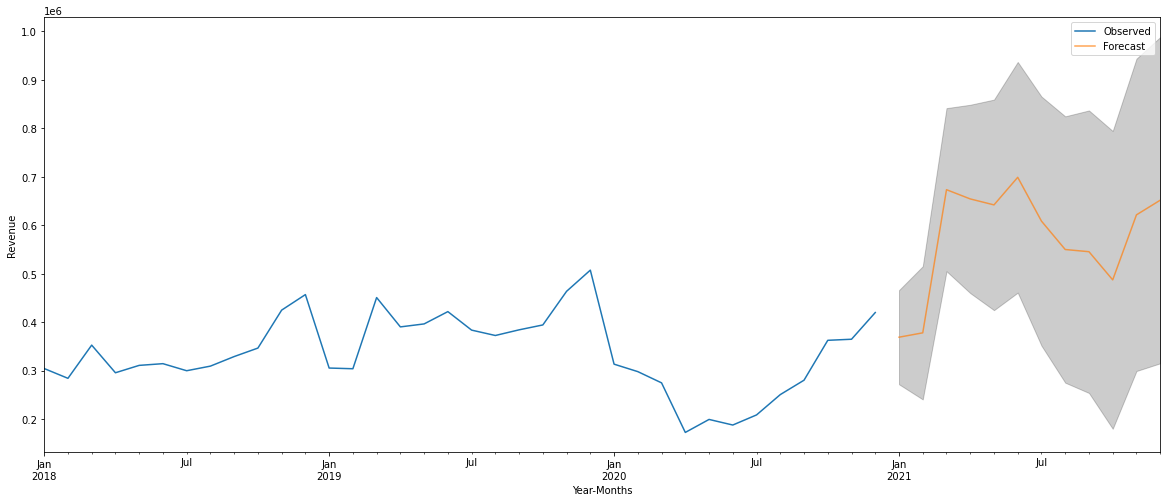

In [114]:
# Plot 2021 Forecast Along with the 95% Confidence Interval Band

axis = dfMobileRevenue['Revenue'].plot(label = 'Observed')
predicted_SARIMA_date['mean'].plot(ax = axis, label = 'Forecast', alpha = 0.7)
axis.fill_between(predicted_SARIMA_date.index, predicted_SARIMA_date['mean_ci_lower'], 
                  predicted_SARIMA_date['mean_ci_upper'], color = 'k', alpha = 0.2)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Revenue')
plt.legend(loc='best')
plt.show()

In [115]:
# Create Data Frame of 2021 predicted values for conversion to CSV File. View Top 5 Rows of Data Frame

predicted_SARIMA_date.reset_index(inplace = True)
predicted_SARIMA_date.columns = ['Date', 'Mean', 'Mean SE', 'Mean Lower CI', 'Mean Upper CI']
predicted_SARIMA_date = predicted_SARIMA_date.round(2)
predicted_SARIMA_date

,Date,Mean,Mean SE,Mean Lower CI,Mean Upper CI
0,2021-01-31,368820.26,49593.32,271619.14,466021.38
1,2021-02-28,377847.27,70135.41,240384.38,515310.16
2,2021-03-31,673332.00,85897.94,504975.14,841688.86
3,2021-04-30,654266.73,99186.36,459865.04,848668.43
4,2021-05-31,641945.85,110893.70,424598.19,859293.52
5,2021-06-30,698905.94,121477.95,460813.53,936998.34
6,2021-07-31,608411.80,131211.17,351242.63,865580.97
7,2021-08-31,549850.30,140270.63,274924.91,824775.69
8,2021-09-30,545309.32,148779.47,253706.93,836911.72
9,2021-10-31,487153.87,156827.32,179777.97,794529.78


In [116]:
# Write Mobile Prediction for Year 2021 to .CSV File ...

predicted_SARIMA_date.to_csv('predMobile2021.csv', encoding = 'utf-8', index = False)

# Part (II): Exploratory Analyses and Modeling for Desktop Devices

In [117]:
# Grouping the Desktop Revenue by Monthly Totals to Predict Total Monthly Revenues via Time Series

dfDesktopRevenue = dfDesktop.groupby(pd.Grouper(key = 'Date', freq = 'M')).agg({'Revenue' : 'sum'})

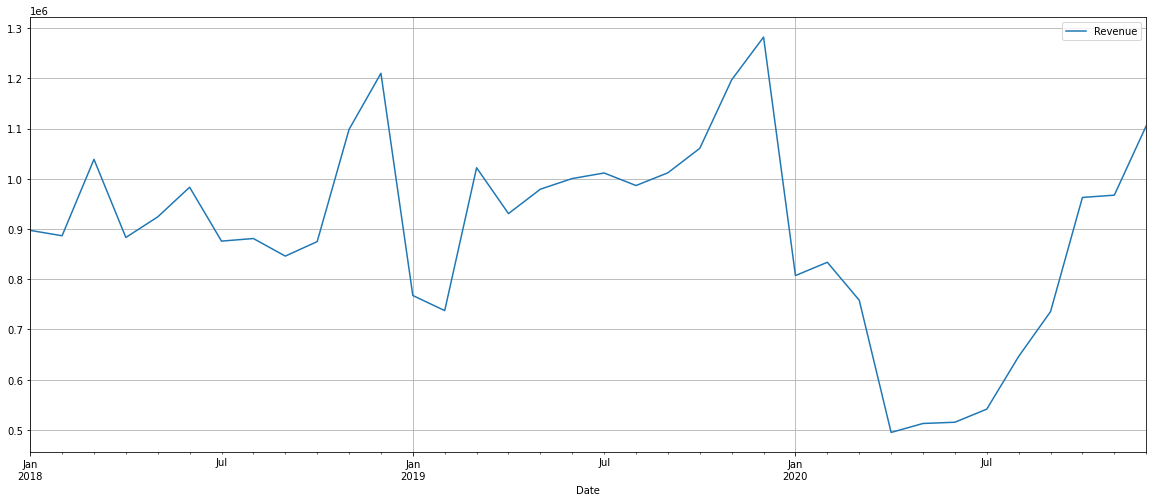

In [118]:
# Time Series Plot of Monthly Desktop Revenue

dfDesktopRevenue.plot()
plt.grid();

**Observations:** The Desktop Revenue Data looks pretty seasonal with Revenues peaking towards the end of the year. Also, there appears to be an increasing trend through each of the years. 2020 Revenues seem to be lower than for 2018 and 2019.

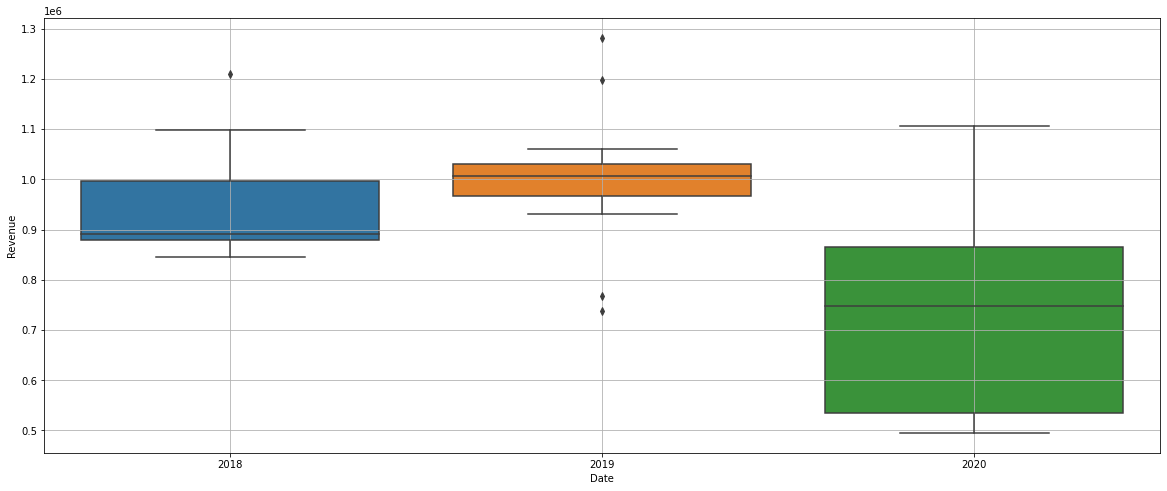

In [119]:
# Yearly Box Plots of Desktop Revenue Data

sns.boxplot(x = dfDesktopRevenue.index.year, y = dfDesktopRevenue['Revenue'])
plt.grid();

**Observations:** Highest in 2019 and somewhat lower in 2018. Revenues considerably down in 2020 with larger spread of data there.

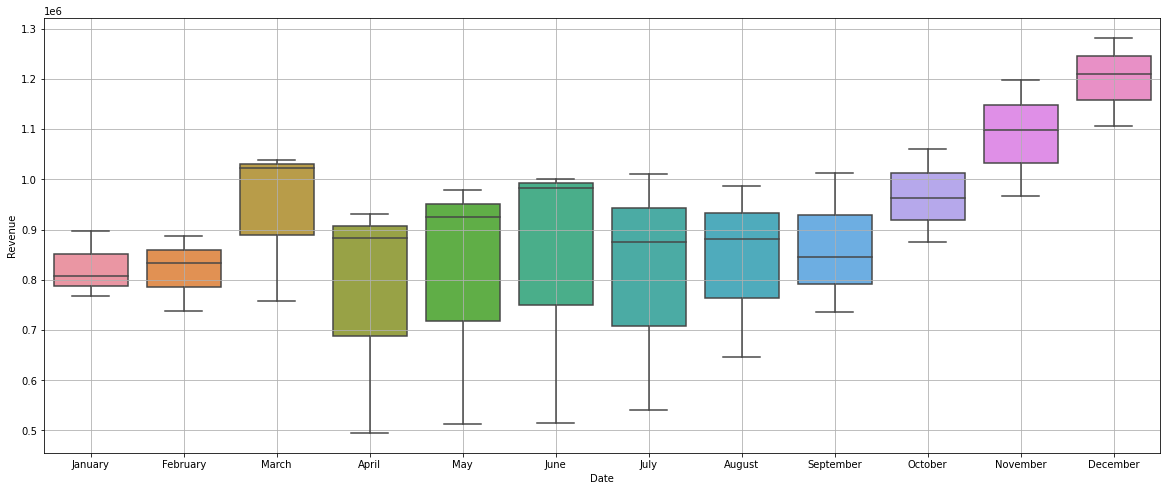

In [120]:
# Monthly Box Plots of Desktop Revenue Data

sns.boxplot(x = dfDesktopRevenue.index.month_name(), y = dfDesktopRevenue['Revenue'])
plt.grid();

**Observations:** Highest in November-December with large spreads in summer months April-July.

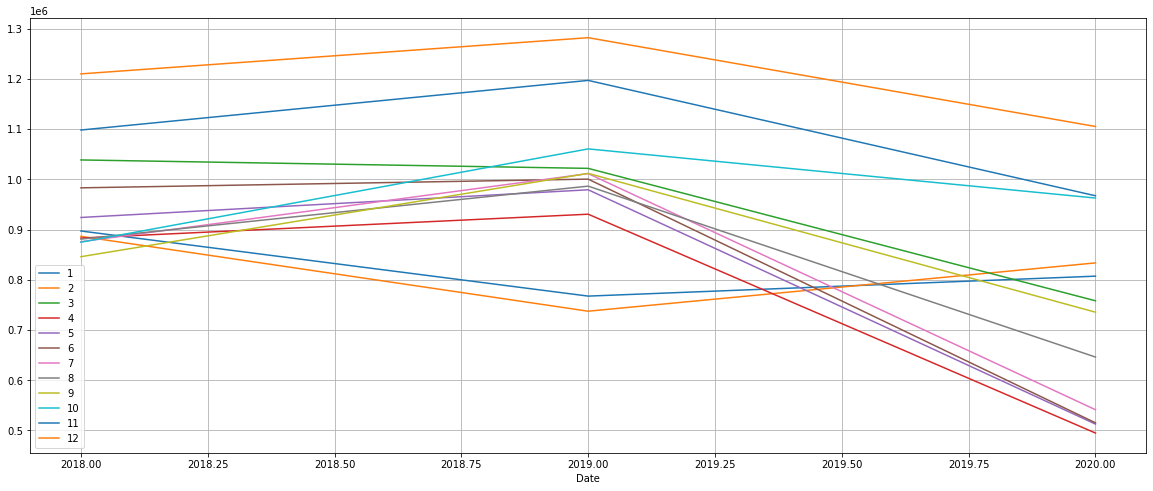

In [121]:
# Pivot Table and Line Plots of Monthly Revenue

annualMonthlySales = pd.pivot_table(data = dfDesktopRevenue, values = 'Revenue', \
                                    columns = dfDesktopRevenue.index.month, index = dfDesktopRevenue.index.year)

annualMonthlySales.plot()
plt.grid()
plt.legend(loc='best');

**Observations:** Highest revenue close to the Holidays in November-December. Low revenue in early part of year. Pretty intuitive.

### Since the data is measuring the same value at successive points in time, where the step-size of the time grid is uniform, we use a Time Series once again for forecasting revenue values for the not too distance future. Therefore, we proceed as follows:

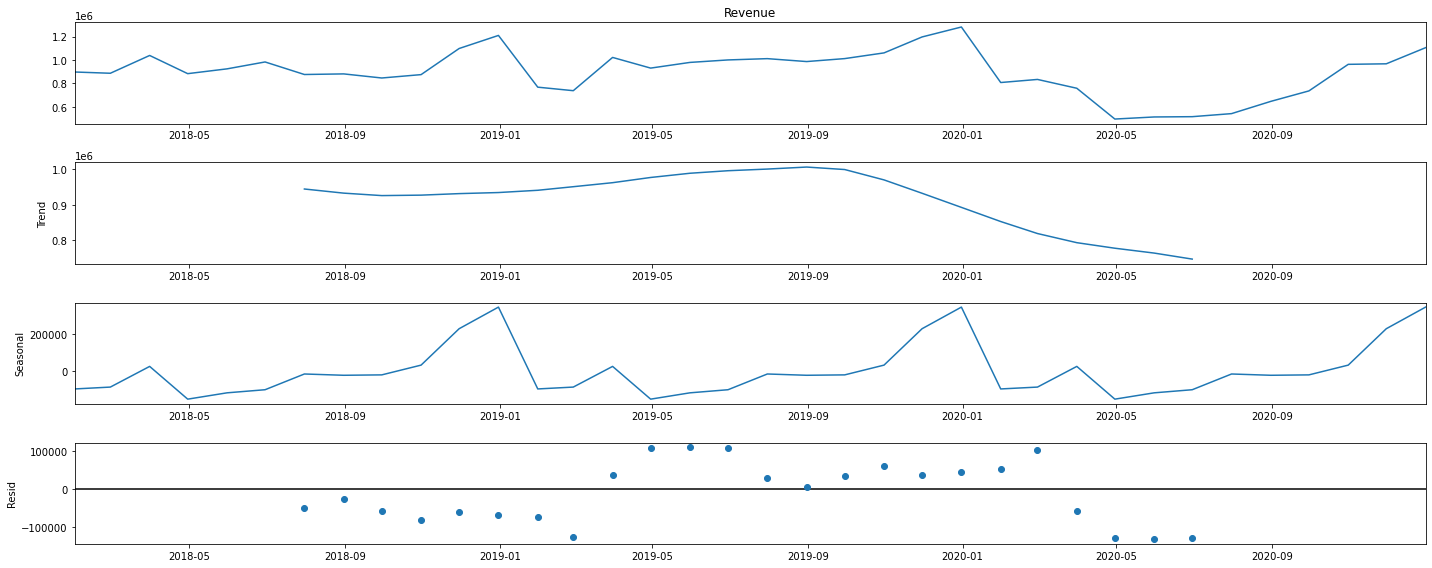

In [122]:
#Decompose Data into Components Using an Additive model

decomposition = seasonal_decompose(dfDesktopRevenue.Revenue, model = 'additive')
decomposition.plot();

**Observations:** Definite seasonality in data. Irregular component, centered at 0, has very high variation.

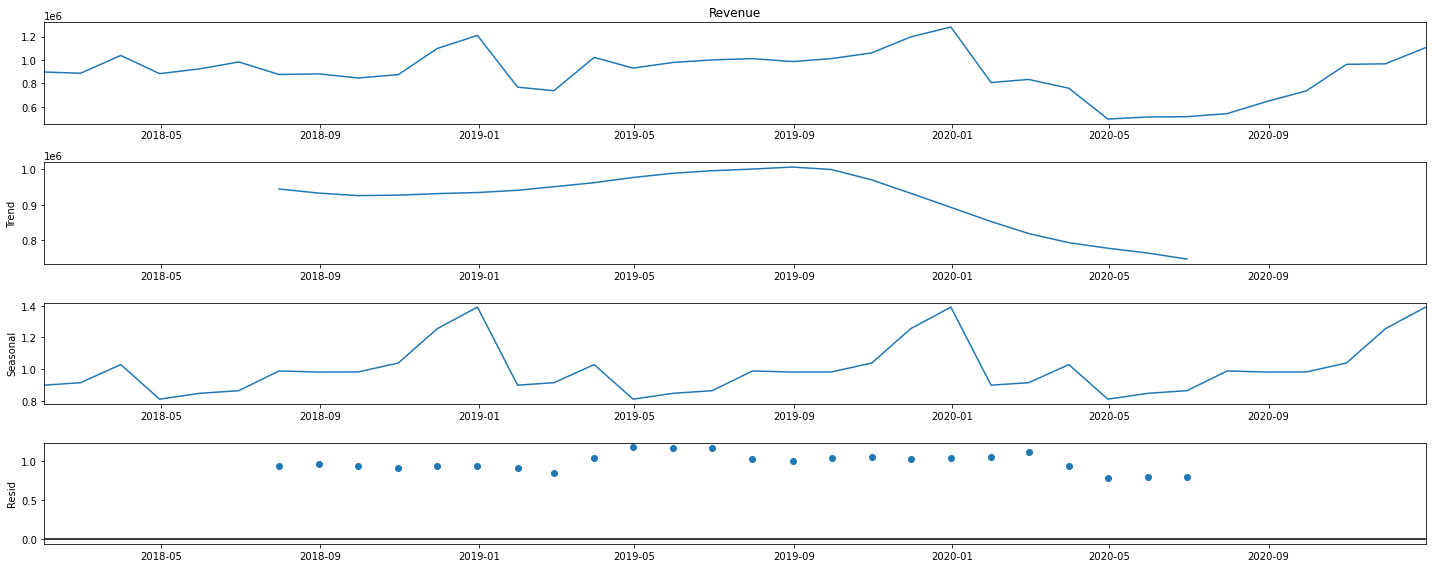

In [123]:
# Decompose Data into Components Using a Multiplicative Model

decomposition = seasonal_decompose(dfDesktopRevenue.Revenue, model = 'multiplicative')
decomposition.plot();

**Observations:** Seasonality in data is visible. Irregularities are centered around 1 and have much lower variance as compared to the additive model.

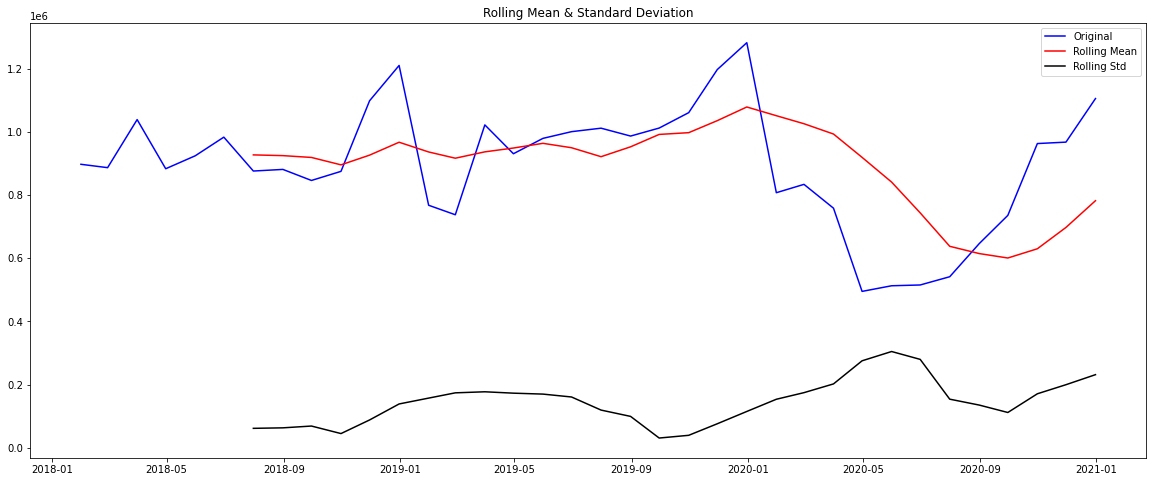

Results of Dickey-Fuller Test:
Test Statistic                 -2.406404
p-value                         0.139937
#Lags Used                      0.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64 



In [124]:
# Test Desktop Revenue Data for Stationarity using the ADF Test and Visualize via function defined earlier

test_stationarity(dfDesktopRevenue.Revenue)

**Observations:** p-value is greater than 0.05 or 5% significance level. Hence we fail to reject the null hypothesis that data has no stationarity.

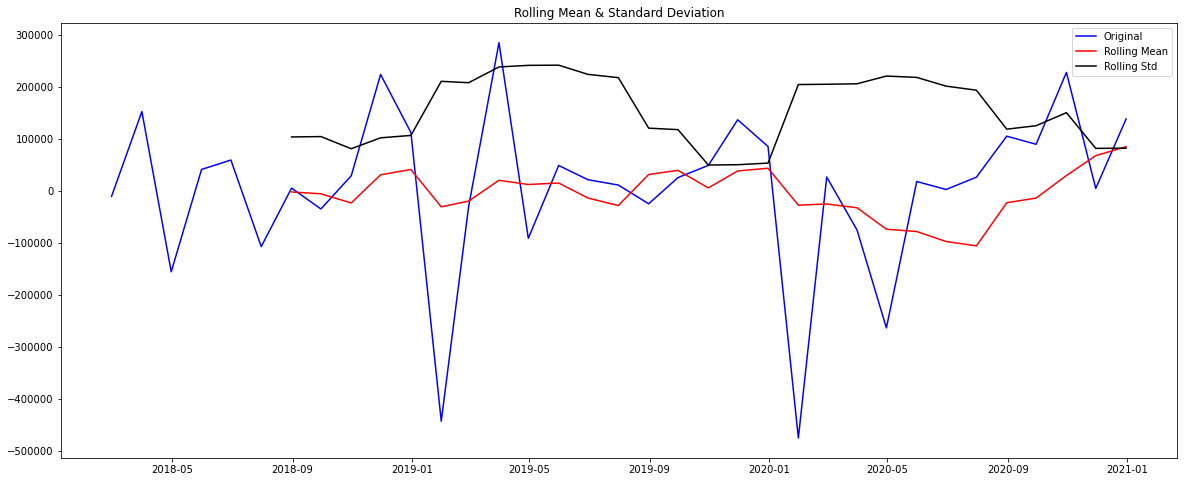

Results of Dickey-Fuller Test:
Test Statistic                -6.075841e+00
p-value                        1.122169e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.400000e+01
Critical Value (1%)           -3.639224e+00
Critical Value (5%)           -2.951230e+00
Critical Value (10%)          -2.614447e+00
dtype: float64 



In [125]:
# Test first-level differenced Desktop Revenue Data for Stationarity

test_stationarity(dfDesktopRevenue.Revenue.diff().dropna())

**Observations:** p-value is less than 0.05 or 5% significance level. Hence we fail to accept the null hypothesis that data has no stationarity. Data has been stationarized. So we will need a difference value of d = D = 1 to apply a time series model to the data.

In [126]:
# Split Desktop Revenue Data into Train (70%) and Test (30%) Data Sets

dataSize = dfDesktopRevenue.shape[0]

TrainRatio = 0.7

TrainSize = int(np.ceil(dataSize * TrainRatio))

dfDesktopRevenueTrain = dfDesktopRevenue[:][0:TrainSize]
dfDesktopRevenueTest = dfDesktopRevenue[:][TrainSize:dataSize]

### Since there is definite Seasonality in the Data, we will use a SARIMA model which stands for Seasonality (S) Auto (A) Regressive (R) Integrated (I) Moving Averages (MA).

In [127]:
# Use the same pdq and model_pdq Cartesian products that were developed for the SARIMAX model used
# for the Mobile Revenue Data Time Series Modeling Earlier

SARIMA_AIC = []

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(dfDesktopRevenueTrain["Revenue"].values,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
        results_SARIMA = SARIMA_model.fit(maxiter = 1000)
        SARIMA_AIC.append([param, param_seasonal, results_SARIMA.aic])

C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /
C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

In [128]:
# Create Data Frame of Akaike Information Criteria (AIC) scores for the models above

SARIMA_AIC = pd.DataFrame(SARIMA_AIC)
SARIMA_AIC.columns = ['Param', 'Seasonal Param', 'AIC']
SARIMA_AIC.sort_values(by = ['AIC'], ascending = True).head()

,Param,Seasonal Param,AIC
1,"(0, 1, 0)","(0, 1, 1, 12)",4.0
30,"(1, 1, 0)","(1, 1, 0, 12)",6.0
2,"(0, 1, 0)","(0, 1, 2, 12)",6.0
28,"(1, 1, 0)","(0, 1, 1, 12)",6.0
4,"(0, 1, 0)","(1, 1, 1, 12)",6.0


**Observations:** Lowest AIC score is for parameter values (p, d, q) = (0, 1, 0) and (P, D, Q, F) = (0, 1, 1, 12)

In [129]:
# Build model with the above optimal (p, d, q) = (0, 1, 0) and (P, D, Q, F) = (0, 1, 1, 12) values.
# Fit model to training data set.

model_SARIMA2 = sm.tsa.statespace.SARIMAX(dfDesktopRevenueTrain['Revenue'].values,
                                order = (0, 1, 0),
                                seasonal_order = (0, 1, 1, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)
results_model_SARIMA = model_SARIMA2.fit(maxiter = 1000)

C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in true_divide
  np.inner(score_obs, score_obs) /


In [130]:
# Predict Using Model Above for points in time equal in length to that of Test Data Set 

predicted_model_SARIMA2 = results_model_SARIMA.get_forecast(steps = dfDesktopRevenueTest.shape[0])

In [131]:
# Top 5 Rows of predictions Data Frame

predicted_model_SARIMA2.summary_frame(alpha = 0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,1118090.60,60365.436879,999776.517807,1.236405e+06
1,1026836.78,85369.619532,859515.400343,1.194158e+06
2,1075452.71,104556.003695,870526.708391,1.280379e+06
3,1096670.28,120730.873757,860042.115614,1.333298e+06
4,1107692.83,134981.220352,843134.499521,1.372251e+06


In [132]:
# Root Mean Square Error (RMSE) between predictions and test data

rmse = MSE(dfDesktopRevenueTest['Revenue'],\
                          predicted_model_SARIMA2.predicted_mean, squared = False)
print('Root Mean Square Error (RMSE) = %.2f' % rmse)

Root Mean Square Error (RMSE) = 439949.39


In [133]:
# Build Time Series SARIMAX Model on Whole Data Set (Test + Train Data Set)

full_data_model2 = sm.tsa.statespace.SARIMAX(dfDesktopRevenue['Revenue'],
                                order = (0, 1, 0),
                                seasonal_order = (0, 1, 1, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)
results_full_data_model = full_data_model2.fit(maxiter = 1000)
print(results_full_data_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              Revenue   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -131.641
Date:                              Sun, 10 Apr 2022   AIC                            267.282
Time:                                      22:39:45   BIC                            267.888
Sample:                                  01-31-2018   HQIC                           266.619
                                       - 12-31-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.8285      0.158     -5.231      0.000      -1.139      -0.518
sigma2      1.202e+

C:\ANACONDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [134]:
# RMSE of Full Data Model

rmse = MSE(dfDesktopRevenue['Revenue'], results_full_data_model.fittedvalues, squared = False)
print('RMSE of the Full Data Model = %.2f' % rmse)
averageMeanColumn = dfDesktopRevenue['Revenue'].mean()
print('Average of Mean Column = %.2f' % averageMeanColumn)

RMSE of the Full Data Model = 291701.79
Average of Mean Column = 896299.56


In [135]:
# Use model above to predict total Monthly Desktop Revenues for future 12 months of year 2021

predicted_SARIMA_full_data = results_full_data_model.get_forecast(steps = 12)

In [136]:
# Top 5 Rows of predicted revenue for 2021

predicted_SARIMA_full_data.summary_frame(alpha = 0.05).head()

Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-31,1.371337e+06,109637.414901,1.156452e+06,1.586222e+06
2021-02-28,1.370341e+06,155050.272414,1.066448e+06,1.674234e+06
2021-03-31,1.415745e+06,189896.843590,1.043554e+06,1.787936e+06
2021-04-30,1.339270e+06,219273.882245,9.095015e+05,1.769039e+06
2021-05-31,1.354068e+06,245155.582569,8.735714e+05,1.834564e+06


In [137]:
# Add monthly dates to revenue prediction of 2021

predicted_SARIMA_date = predicted_SARIMA_full_data.summary_frame\
(alpha = 0.05).set_index(pd.date_range(start = '2021-01-31', end = '2021-12-31', freq = 'M'))

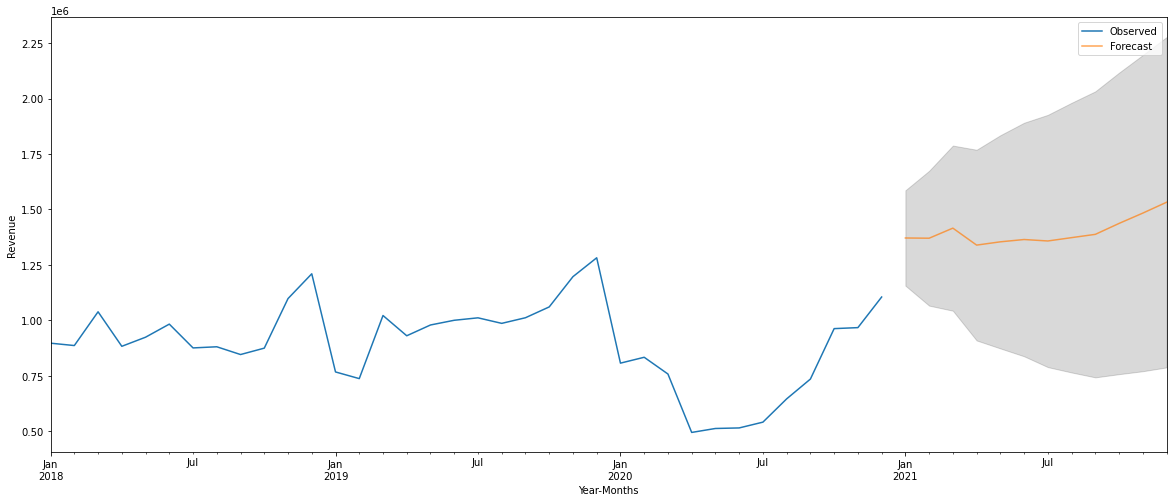

In [138]:
# Plot the 2021 Revenue Forecast along with the 95% Confidence Interval band

axis = dfDesktopRevenue['Revenue'].plot(label='Observed')
predicted_SARIMA_date['mean'].plot(ax = axis, label = 'Forecast', alpha = 0.7)
axis.fill_between(predicted_SARIMA_date.index, predicted_SARIMA_date['mean_ci_lower'], 
                  predicted_SARIMA_date['mean_ci_upper'], color ='k', alpha = .15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Revenue')
plt.legend(loc='best')
plt.show()

In [139]:
# Create Data Frame of 2021 predicted values for conversion to CSV

predicted_SARIMA_date.reset_index(inplace = True)
predicted_SARIMA_date.columns = ['Date', 'Mean', 'Mean SE', 'Mean Lower CI', 'Mean Upper CI']
predicted_SARIMA_date = predicted_SARIMA_date.round(2)
predicted_SARIMA_date

,Date,Mean,Mean SE,Mean Lower CI,Mean Upper CI
0,2021-01-31,1371337.10,109637.41,1156451.71,1586222.48
1,2021-02-28,1370340.88,155050.27,1066447.93,1674233.83
2,2021-03-31,1415745.32,189896.84,1043554.34,1787936.29
3,2021-04-30,1339270.38,219273.88,909501.47,1769039.30
4,2021-05-31,1354067.55,245155.58,873571.44,1834563.66
5,2021-06-30,1364459.98,268554.43,838102.96,1890817.00
6,2021-07-31,1357871.58,290071.90,789341.10,1926402.06
7,2021-08-31,1372927.74,310099.87,765143.16,1980712.33
8,2021-09-30,1387735.34,328910.56,743082.48,2032388.19
9,2021-10-31,1437064.85,346702.15,757541.12,2116588.57


In [140]:
# Write Desktop Prediction for Year 2021 to .CSV File ...

predicted_SARIMA_date.to_csv('predDesktop2021.csv', encoding = 'utf-8', index = False)

# Part (III): Questions

**Question 1. What forecasting model did you choose to use and why?**

**Answer:** The forecasting model used for both the mobile as well as desktop revenues was the **SARIMAX (Seasonal, Auto-Regressive, Moving Averages)** model for the following reasons:

* The data is present in a Time Series compatible format. In that, for each type of product, the same variable, viz.  Revenue, is being measured at successive points in time which are the successive days of three years 2018-2020. The step-size for time has a constant value of one day. There is no missing or unclean data which is fantastic and makes the implementation of the model that much easier.

* Data points are not independent. Each day's revenue is dependent on the previous day's revenue which again calls for a Time Series approach.

* As per the visualizations created in the notebook, there is irregularity and seasonality in the data which calls for a **SARIMAX** model implemented via Python. This model deftly handles the irregular and seasonal components in the time-series data and is used to give a total monthly revenue prediction for each of the months of the year 2021.


**Question 2. How did you validate your model? Please provide quantitative validation for your model with an explanation to what it means.**

**Answer:** For the different parameters (p, d, q) and (P, D, Q, F) in the SARIMAX model, the **Akaike Information Criterion (AIC)** is used to validate which combination of parameters produces the most optimal model. The **AIC** is a mathematical and statistical method used to evaluate how well a model fits the data it is generated from. In statistics, **AIC** is used to compare different possible models and determine which one is the best fit for the data. Mathematically speaking, we define 

$$
AIC = 2k - 2 \ln (L) \qquad (1)
$$

In (1) above, $k$ equals the number of parameters in the model, while $L$ is the likelihood function of the model which is the joint probabilty $P(X | \theta)$, where $X$ is the observed data and $\theta$ is the parameter set. The objective is to find the opitmal model that has a minimum **AIC** value or the maximum $L$ value $\hat{L}$.

From the different models that were built we chose the (p, d, q) and (P, D, Q, F) values that minimized the **AIC** value for each of the Mobile as well as the Desktop Revenue models. These models were then used to forecast the 2021 revenue values.

The lowest AIC scores from running the SARIMAX models were 4 for both the Mobile as well as the Desktop Revenues. For both the Mobile and Desktop Revenue Time Series Models, the corresponding parameter values obtained were (p, d, q) = (0, 1, 0) and (P, D, Q, F) = (0, 1, 1, 12).

Using the SARIMAX models built from the optimal parameter values above, the Root Mean Squared Error (RMSE) between the whole observed data set $X$ and its SARIMAX model forecast $\hat{X}$, both having size $n$, is then calculated as follows:

$$
\displaystyle
RMSE = \sqrt{ \frac{\sum_n \left(X-\hat{X} \right)^2}{n} }
$$

The RMSE value obtained for the full data model for the Mobile Revenue was approximately 140,000 against the average monthly total value of close to 330,000. The corresponding figures for the Desktop Revenue was approximately 300,000 and 900,000, respectively.


**Question 3. What challenges did you face during the process?**

**Answer:** The python packages performed well in the Exploratory Data Analysis (EDA) as well as in creating the Time Series-based 2021 forecasts. One warning repeatedly issued by SARIMAX, while fitting the model to training data, was that there were ***Too few observations to estimate starting parameters for seasonal ARMA***. Hence, since the time series forecast of one full year was a significant portion (33%) of the whole data set of three years, data on a few more years preceeding 2018 would have been more beneficial as regards the forecast accuracy. Overall I had fun with it. It was highly enjoyable working on this project.


**Question 4. Did you face any challenges from the data itself?**

**Answer:** The data was clean and had no missing or duplicate values which was great and is rather unlike real world data. It was pretty easy to read into a dataframe. Following the time series modeling, the 2021 predictions were written to two CSV files. The data as a time series had a high irregularity component which may have contributed to the large width of the 95% confidence band intervals in the 2021 predictions. Further, the dynamics of the 2020 data, as per the EDA were significantly different from 2018 and 2019. Again, the availability of more years' data prior to 2018 could have helped with these data issues. 